### Walker experiment

In [1]:
import os, sys
%env CUDA_VISIBLE_DEVICES=0
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import joblib
from datetime import datetime
print("Numpy: {}, Torch: {}, Joblib: {}".format(np.__version__, torch.__version__, joblib.__version__))
assert joblib.__version__ == '0.13.2', 'this is important for global_variables. proceed at your own risk.'

env: CUDA_VISIBLE_DEVICES=0
Numpy: 1.15.2, Torch: 1.0.1.post2, Joblib: 0.13.2


__Download__ vertices and hnsw edges, prepare paths and ground truth neighbors

In [2]:
DATA_DIR = './data/SIFT1M'

if not os.path.exists(DATA_DIR):
    assert not DATA_DIR.endswith(os.sep), 'please do not put "/" at the end of DATA_DIR'
    !mkdir -p {DATA_DIR}
    !wget https://www.dropbox.com/sh/vs2jjn3545kqni3/AADphiKkLX9gBKyXQ-E5x53Ca?dl=1 -O {DATA_DIR}/sift_1m.zip
    !cd {DATA_DIR} && unzip sift_1m.zip

In [3]:
import lib
import os.path as osp

graph_params = { 
    'vertices_path': osp.join(DATA_DIR, 'sift_base.fvecs'),
    'edges_path': osp.join(DATA_DIR, 'test_hnsw_M12_ef300_onelevel1.ivecs'),
    'initial_vertex_id': 0,         # by default, starts search from this vertex
    
#   'edges_path': osp.join(DATA_DIR, 'test_hnsw_M12_ef300_onelevel0.ivecs'),
#   'info_path': osp.join(DATA_DIR, 'test_hnsw_M12_ef300_onelevel0.bin'),
#   ^-- uncomment this to get hierarchical nsw
    
    'train_queries_path': osp.join(DATA_DIR, 'sift_learn.fvecs'),
    'test_queries_path': osp.join(DATA_DIR, 'sift_query.fvecs'),
    
    'train_gt_path': osp.join(DATA_DIR, 'train_gt.ivecs'),
    'test_gt_path': osp.join(DATA_DIR, 'test_gt.ivecs'),
#     ^-- comment these 2 lines to re-compute ground truth ids (if you don't have pre-computed ground truths)

    'ground_truth_n_neighbors': 1,  # for each query, finds this many nearest neighbors via brute force
}
graph = lib.Graph(**graph_params)

__HNSW parameters:__ distance computation budget, reranking budget, metrics

In [4]:
total_dcs = 256

routing_dcs = 248
routing_vector_size = 128
verification_top_k = 8

architecture = 'ffn'       # 'gcn' or 'ffn' or whatever you define manually
max_batches  = 80000       # num training iterations; use float('inf') for unlimited

# one cycle learning rate schedule
learning_rate_base = 1e-3
warmup_steps = 5000
decay_rate = 1./3
learning_rate_min = 1e-5
batch_size = 1024
dev_batch_size = 100

# batch generator
sampling_temperature = 1.0
sampling_chunk_size = 10000
n_jobs = 8

exp_name = '{data_name}_dcs{total_dcs}_{architecture}_size{routing_vector_size}_routing{routing_dcs}_verification{verification_top_k}'.format(
    data_name=osp.split(DATA_DIR)[-1], total_dcs=total_dcs, routing_vector_size=routing_vector_size, routing_dcs=routing_dcs,
    verification_top_k=verification_top_k, architecture=architecture
)
print('exp name:', exp_name)
!rm {'./runs/' + exp_name} -rf # KEEP COMMENTED!
assert not os.path.exists('./runs/' + exp_name)

original_vector_size = graph.vertices.shape[-1]
is_compressed = (routing_vector_size != graph.vertices.shape[1])
if not is_compressed:
    projection_cost = 0
else:
    projection_cost = routing_vector_size 
sanity_check_dcs = round(routing_dcs * routing_vector_size / original_vector_size + projection_cost + verification_top_k)
assert total_dcs == sanity_check_dcs, "current scheme has {} dcs out of {} required".format(sanity_check_dcs, total_dcs)


exp name: SIFT1M_dcs256_ffn_size128_routing248_verification8


In [5]:
hnsw = lib.hnsw.WalkerHNSW(graph, max_dcs=routing_dcs,
                           top_vertices_for_verification=verification_top_k,
                           distance_for_verification=lib.hnsw.DISTANCES['euclidian'],
                           distance_for_routing=lib.hnsw.DISTANCES['negative_dot'],
                           hierarchical=False
)

__Agent and Trainer__

In [6]:
from tensorboardX import SummaryWriter

if architecture == 'gcn':
    agent = lib.walker_agent.GCNWalkerAgent(
        graph.vertices.shape[1], conv_hid_size=256, hidden_size=1024, output_size=routing_vector_size, 
        residual=not is_compressed, project_query=is_compressed
    ).to(device='cuda')

elif architecture == 'ffn':
    agent = lib.walker_agent.SimpleWalkerAgent(
        graph.vertices.shape[1], hidden_size=4096, output_size=routing_vector_size, 
        residual=not is_compressed, project_query=is_compressed
    ).to(device='cuda')

else:
    raise ValueError("Unknown architecture: {}".format(architecture))

oracle = lib.ParallelBFS(graph_edges=graph.edges)

trainer = lib.SupervisedWalkerTrainer(
    agent, hnsw, oracle, writer=SummaryWriter('runs/' + exp_name),
    learning_rate_base=learning_rate_base, warmup_steps=warmup_steps,
    decay_rate=decay_rate, learning_rate_min=learning_rate_min,
)

__Training loop__

In [7]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

train_loss_history, train_acc_history, dev_recall_history = [], [], []

In [8]:
# generates batches of [queries, ground truth]
dev_batcher = lib.utils.iterate_minibatches(graph.test_queries, graph.test_gt, batch_size=dev_batch_size)

# generates batches of [records] for training
train_batcher = trainer.generate_training_batches(
    graph.train_queries, graph.train_gt,
    queries_per_chunk=sampling_chunk_size, batch_size_max=batch_size,
    sampling_temperature=sampling_temperature, n_jobs=n_jobs,
)

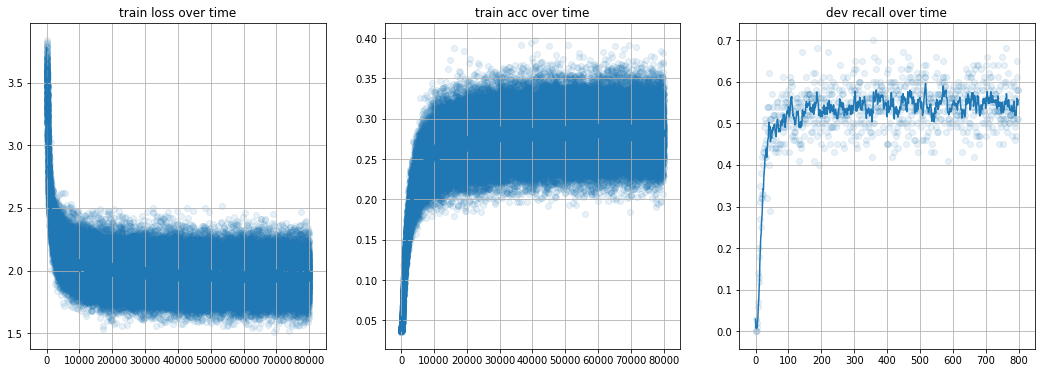

step=80000, mean_loss=1.964, time=0.074
____________________________________________________________________________________________________
.

In [9]:
for batch_records in train_batcher:
    metrics_t = trainer.train_on_batch(batch_records)
    train_loss_history.append(metrics_t['loss'].item())
    train_acc_history.append(metrics_t['acc'].item())
    print(end='.')
    
    if trainer.step % 100 == 0:
        dev_metrics_t = trainer.compute_dev_metrics_on_batch(*next(dev_batcher))
        dev_recall_history.append(dev_metrics_t['recall'])
    
    if trainer.step % 5000 == 0:
        print(end="Saving...")
        torch.save(agent, "runs/{}/agent.{}.pth".format(exp_name, trainer.step))
        torch.save(trainer.opt, "runs/{}/opt.{}.pth".format(exp_name, trainer.step))
        print('Done!')
        
    if trainer.step % 100 == 0:
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 3, 1)
        plt.title('train loss over time'); plt.grid();
        plt.plot(moving_average(train_loss_history, span=50))
        plt.scatter(range(len(train_loss_history)), train_loss_history, alpha=0.1)
        plt.subplot(1, 3, 2)
        plt.title('train acc over time'); plt.grid();
        plt.plot(moving_average(train_acc_history, span=50))
        plt.scatter(range(len(train_acc_history)), train_acc_history, alpha=0.1)
        plt.subplot(1, 3, 3)
        plt.title('dev recall over time'); plt.grid();
        plt.plot(moving_average(dev_recall_history, span=10))
        plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
        plt.show()
        
        print("step=%i, mean_loss=%.3f, time=%.3f" % 
              (len(train_loss_history), np.mean(train_loss_history[-100:]), metrics_t['step_time']))
        print('_' * 100)
    
    if trainer.step > max_batches: break
        
#protip: run tensorboard in ./runs to get all metrics.

In [10]:
def compute_recalls(queries, gt, hnsw=hnsw, agent=agent, wrap=lambda x:x, **kwargs):
    """ Compute recall, mean distance computations and mean number of hops """
    with torch.no_grad():
        state = agent.prepare_state(graph, device='cuda')
        predictions = [hnsw.find_nearest(q, state=state, agent=agent) for q in wrap(queries)]
        
    answers = [prediction['best_vertex_id'] for prediction in predictions]
    mean_recall = np.mean([best in gt for best, gt in zip(answers, gt)])
    distances = [prediction['routing_dcs'] for prediction in predictions]
    hops = [prediction['num_hops'] for prediction in predictions]
    return dict(recall=mean_recall, dcs=np.mean(distances), hops=np.mean(hops))

In [11]:
metrics = compute_recalls(graph.test_queries, graph.test_gt)
print("Eval at step {step}: recall: {recall}, dcs: {dcs}, hops: {hops}".format(step=trainer.step, **metrics))

Eval at step 80001: recall: 0.5453, dcs: 248.0, hops: 15.2881


In [12]:
# NSW M12 for 256 DCS: Recall@1 = 0.4916
# HNSW M12 for 256 DCS:  Recall@1 = 0.5933